## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on eBOSS P1D data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import data_Chabanier2019
from cup1d.data import data_Karacayli2022
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Set up data (eBOSS P1D measurement from Chabanier et al. 2019)

In [2]:
zmin=2.9
zmax=3.3

In [3]:
data=data_Chabanier2019.P1D_Chabanier2019(zmin=zmin,zmax=zmax)

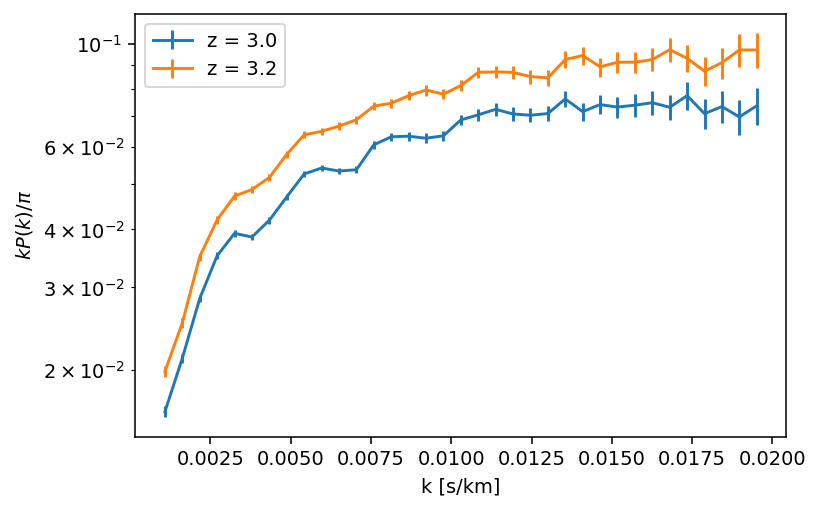

In [4]:
data.plot_p1d()

### Set up high-res extra data (eBOSS P1D measurement from Karacayli et al. 2022)

Nz = 15 , Nk = 21


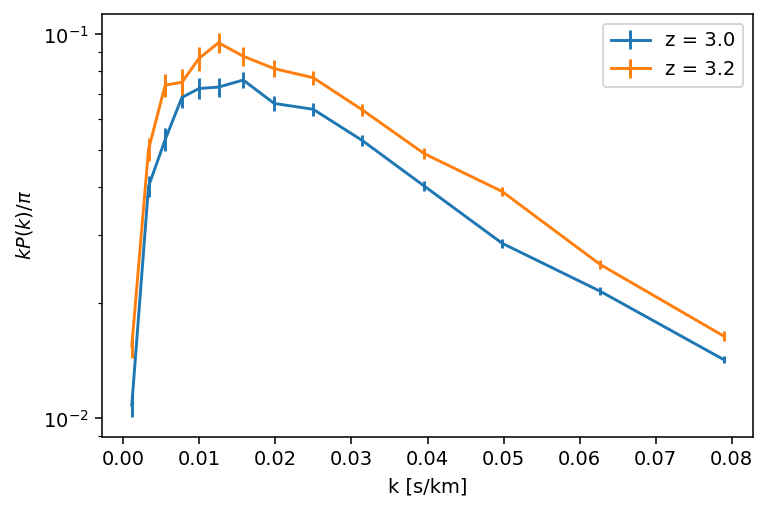

In [5]:
add_hires=True
if add_hires:
    extra_data=data_Karacayli2022.P1D_Karacayli2022(zmin=zmin,zmax=zmax)
    extra_data.plot_p1d()
    emu_kmax_Mpc=8
    emu_ndeg=7
else:
    extra_data=None
    emu_kmax_Mpc=4
    emu_ndeg=5

### Setup an emulator (Nyx, LaCE-GP or LaCE-NN)

In [6]:
emulator_label="LaCE-GP"
if emulator_label=="LaCE-GP":
#    emulator=gp_emulator.GPEmulator(training_set="Cabayol23", kmax_Mpc=emu_kmax_Mpc, ndeg=emu_ndeg)
    emulator=gp_emulator.GPEmulator(training_set="Pedersen21", kmax_Mpc=emu_kmax_Mpc, ndeg=emu_ndeg)
elif emulator_label=="LaCE-NN":
    assert not add_hires,"NN emulator not trained beyond k=4 1/Mpc"
    emulator=nn_emulator.NNEmulator(training_set="Cabayol23", emulator_label="Cabayol23")
elif args.emulator_label=="Nyx":
    assert not add_hires,"Nyx emulator not trained beyond k=4 1/Mpc"
    emulator=nn_emulator.NNEmulator(training_set="Nyx23", emulator_label="Cabayol23_Nyx")
else:
    raise ValueError("wrong emulator_label",emulator_label)

Selected training set from Pedersen21
Selected custom emulator


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.78 seconds


### Setup a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [7]:
free_cosmo=False
if free_cosmo:
    # stick to primordial power-law parameters here
    free_param_names=["As","ns"]
else:
    free_param_names=[]
# specify the number of free parameters per IGM function (default=2)
n_igm=1
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))
# add metal line contaminations
free_param_names.append('ln_SiIII_0')

In [8]:
theory=lya_theory.Theory(zs=data.z,emulator=emulator,free_param_names=free_param_names)

metal tag ln_SiIII


In [9]:
theory.metal_models[0].get_dv_kms()

2260.6866995155115

In [10]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,
                            theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)

will not store truth, working with real data
will not store truth, working with real data


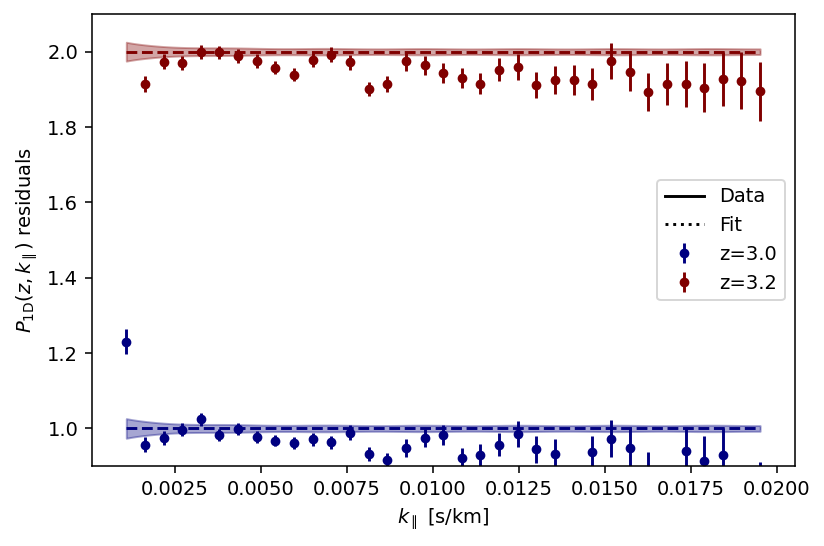

In [11]:
like.plot_p1d(residuals=True,plot_every_iz=1)

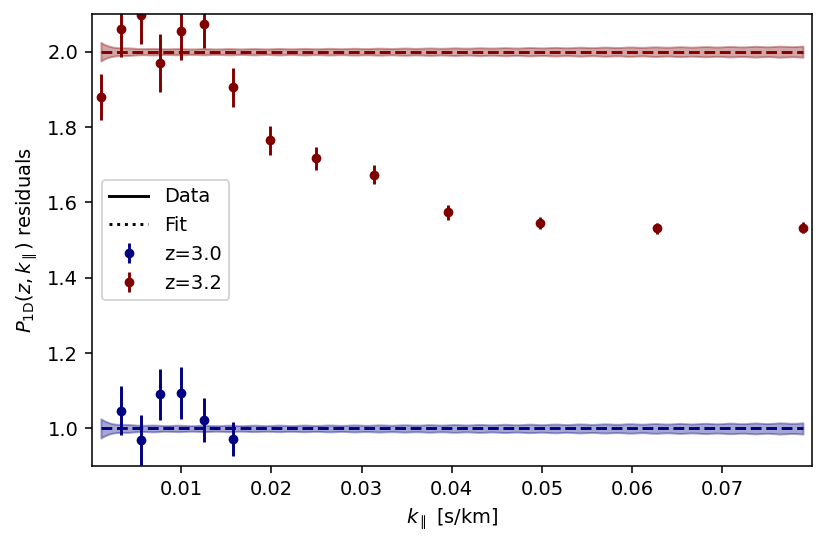

In [12]:
if extra_data:
    like.extra_p1d_like.plot_p1d(residuals=True,plot_every_iz=1)

# Try iminuit minimizer

In [13]:
test_values=len(free_param_names)*[0.5]
ini_chi2=like.get_chi2(values=test_values)
print('chi2 =',ini_chi2)

chi2 = 281.9933385660104


In [14]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [15]:
minimizer.minimize(compute_hesse=True)

In [16]:
best_fit_values=np.array(minimizer.minimizer.values)
best_chi2=like.get_chi2(values=best_fit_values)
print('chi2 improved from {} to {}'.format(ini_chi2,best_chi2))

chi2 improved from 281.9933385660104 to 178.27982019938932


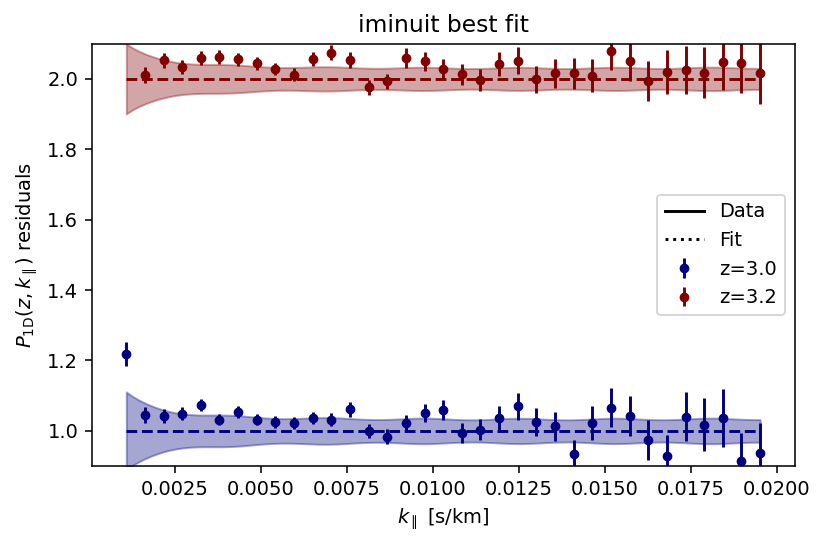

In [17]:
minimizer.plot_best_fit(plot_every_iz=1,residuals=True)

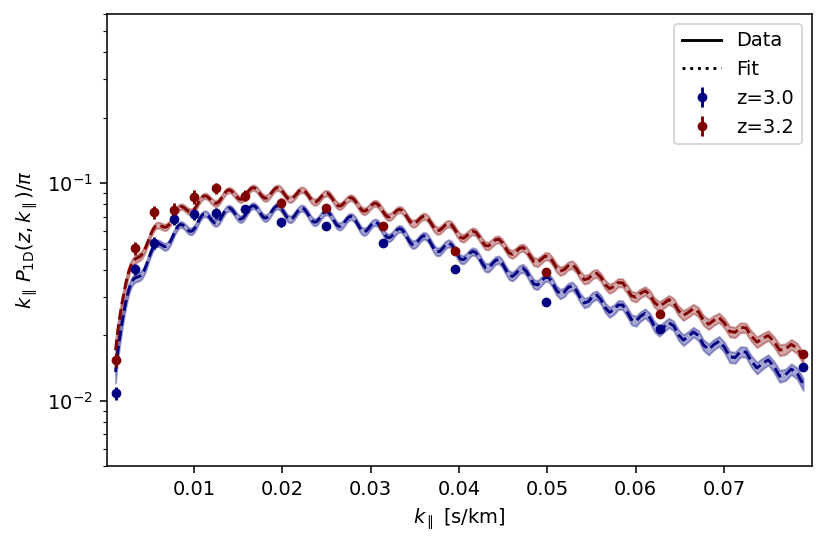

In [18]:
if extra_data:
    like.extra_p1d_like.plot_p1d(values=best_fit_values,residuals=False,plot_every_iz=1)

0 ix ln_tau_0
2 iy ln_gamma_0
0.3671573186447421 x 0.07766252265657751
0.8652333769353753 y 0.01415369679764784
-0.026568536271051588 x 0.015532504531315503
0.14609335077415014 y 0.005661478719059136


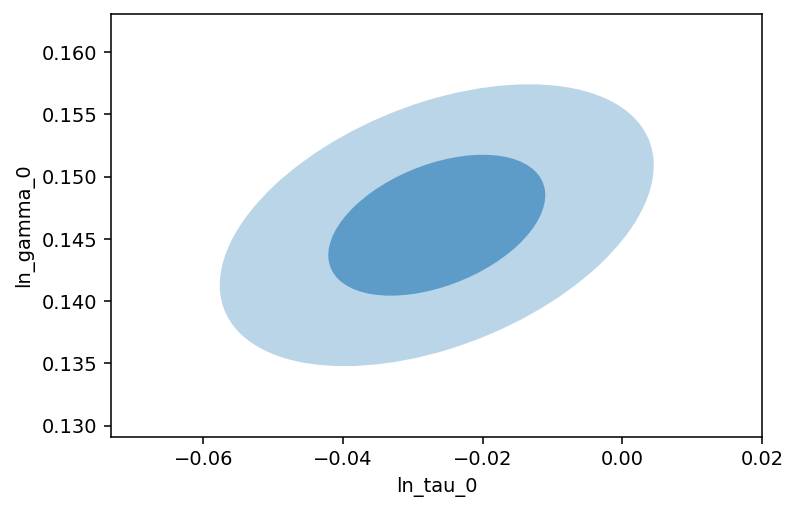

In [19]:
minimizer.plot_ellipses('ln_tau_0','ln_gamma_0')

1 ix ln_sigT_kms_0
2 iy ln_gamma_0
0.772593826765881 x 0.009012721878115498
0.8652333769353753 y 0.01415369679764784
0.21807506141270483 x 0.007210177502492399
0.14609335077415014 y 0.005661478719059136


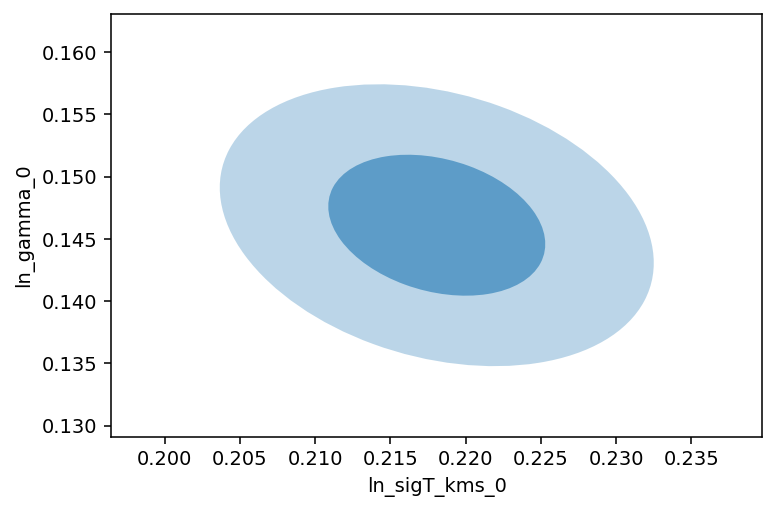

In [20]:
minimizer.plot_ellipses('ln_sigT_kms_0','ln_gamma_0')

1 ix ln_sigT_kms_0
3 iy ln_kF_0
0.772593826765881 x 0.009012721878115498
0.35771962014107767 y 0.038343358173600205
0.21807506141270483 x 0.007210177502492399
-0.05691215194356894 y 0.015337343269440083


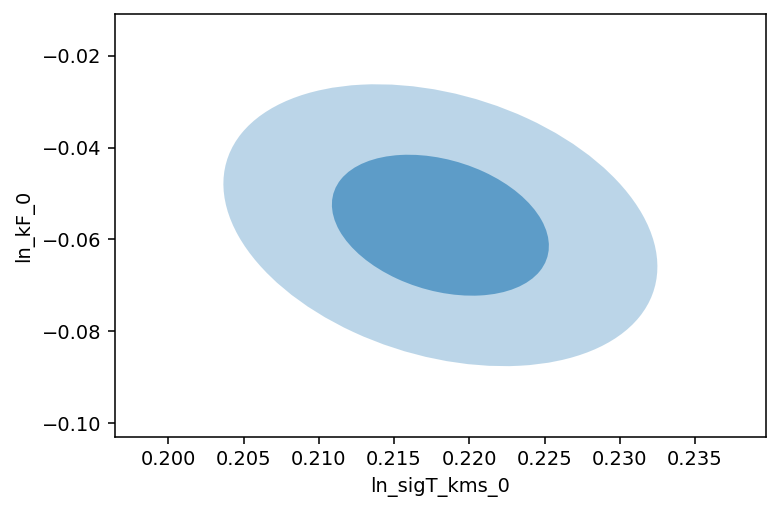

In [21]:
minimizer.plot_ellipses('ln_sigT_kms_0','ln_kF_0')

1 ix ln_sigT_kms_0
4 iy ln_SiIII_0
0.772593826765881 x 0.009012721878115498
0.5 y 5.994901897173903e-51
0.21807506141270483 x 0.007210177502492399
-49.5 y 6.054850916145642e-49


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/cup1d-0.1.0-py3.8.egg/cup1d/likelihood/iminuit_minimizer.py:173: UserWarning:Attempting to set identical bottom == top == -49.5 results in singular transformations; automatically expanding.


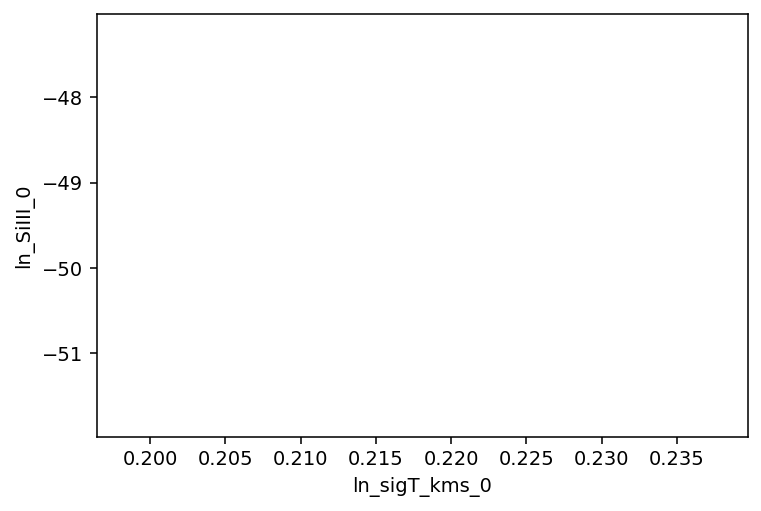

In [22]:
minimizer.plot_ellipses('ln_sigT_kms_0','ln_SiIII_0')

### Access the actual minimizer object from iminuit

In [23]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 272.8                      │              Nfcn = 503              │
│ EDM = 5.55e-07 (Goal: 0.0001)    │           time = 20.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 3.6721e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 1 │ x1   │ 7.7259e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 2 │ x2   │ 8.6524e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 3 │ x3   │ 3.5771e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 4 │ x4   │   5e-1    │   0e-1    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [24]:
#minimizer.minimizer.draw_mncontour("x0", "x1")

In [25]:
#minimizer.minimizer.draw_mnprofile("x0")